In [1]:
import os
import sys
import torch
import random
import imageio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

parent_dir = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
sys.path.insert(0, parent_dir)

from face_lib.datasets import IJBDataset, IJBCTest
from face_lib.utils import cfg
from face_lib.utils.feature_extractors import extract_features_head, extract_features_gan
from face_lib.utils.reject_verification import get_features_sigmas_labels
from face_lib.utils.fusion_metrics import classifier_to_distance_wrapper, classifier_to_uncertainty_wrapper, split_wrapper
from face_lib import models as mlib, utils
from face_lib.utils.imageprocessing import preprocess
from face_lib.utils.utils import harmonic_mean

import matplotlib.pyplot as plt

In [2]:
## Classifier
#python3 ./face_lib/utils/reject_verification.py \
#  --checkpoint_path=/gpfs/data/gpfs0/k.fedyanin/space/models/pair_classifiers/01_smart_cos \
#  --dataset_path=/gpfs/gpfs0/k.fedyanin/space/IJB/aligned_data_for_fusion/big \
#  --pairs_table_path=/gpfs/gpfs0/k.fedyanin/space/IJB/aligned_data_for_fusion/metadata_refuse_verification/pairs_100000_prob_0.5.csv \
#  --config_path=./configs/models/pair_classifiers/smart_cosine.yaml \
#  --batch_size=64 \
#  --distaces_batch_size=100 \
#  --uncertainty_strategy=classifier \
#  --FARs 0.0001 0.0005 0.001 0.005 0.01 0.05 \
#  --rejected_portions $(seq 0 0.002 0.2) \
#  --distance_uncertainty_metrics classifier_classifier cosine_classifier MLS_classifier cosine_harmonic-sum \
#  --device_id=0 \
#  --save_fig_path=/gpfs/data/gpfs0/r.kail/figures/test
##  --save_fig_path=/gpfs/data/gpfs0/r.kail/figures/classifiers/classifier_smart_cosine/

In [3]:
device_id = 0

config_path = "../configs/models/pair_classifiers/smart_cosine.yaml"
checkpoint_path = "/gpfs/data/gpfs0/k.fedyanin/space/models/pair_classifiers/01_smart_cos/checkpoints/sota.pth"
dataset_path = "/gpfs/gpfs0/k.fedyanin/space/IJB/aligned_data_for_fusion/big"
pairs_table_path = "/gpfs/gpfs0/k.fedyanin/space/IJB/aligned_data_for_fusion/metadata_refuse_verification/pairs_1000000_prob_0.5.csv"
# discriminator_path = "/gpfs/data/gpfs0/k.fedyanin/space/GAN/stylegan.pth"
discriminator_path = None
batch_size=16
distaces_batch_size=16

use_classifier = True

In [4]:
device = torch.device("cuda:" + str(device_id))

model_args = cfg.load_config(config_path)
backbone = mlib.model_dict[model_args.backbone["name"]](
    **utils.pop_element(model_args.backbone, "name")
)
head = mlib.heads[model_args.head.name](
    **utils.pop_element(model_args.head, "name")
)

checkpoint = torch.load(checkpoint_path, map_location=device)
backbone.load_state_dict(checkpoint["backbone"])
head.load_state_dict(checkpoint["head"])

backbone, head = backbone.eval().to(device), head.eval().to(device)

discriminator = None
if discriminator_path:
    discriminator = mlib.StyleGanDiscriminator()
    discriminator.load_state_dict(torch.load(discriminator_path)["d"])
    discriminator.eval().to(device)
    

classifier = None
if use_classifier:
    classifier_name = model_args.pair_classifier.pop("name")
    classifier = mlib.pair_classifiers[classifier_name](
        **model_args.pair_classifier,
    )
    classifier.load_state_dict(checkpoint["pair_classifier"])
    classifier = classifier.eval().to(device)

In [5]:
mu_1, mu_2, sigma_sq_1, sigma_sq_2, label_vec = get_features_sigmas_labels(
    backbone, head, dataset_path, pairs_table_path,
    uncertainty_strategy="classifier", batch_size=batch_size, discriminator=discriminator,
)

100%|██████████| 8059/8059 [16:30<00:00,  8.13it/s]


In [6]:
distance_name = "classifier"
uncertainty_name = "classifier"

print(f"=== {distance_name} {uncertainty_name} ===")
if distance_name == "classifier":
    distance_func = classifier_to_distance_wrapper(
        classifier, device=device)
else:
    distance_func = name_to_distance_func[distance_name]

if uncertainty_name == "classifier":
    uncertainty_func = classifier_to_uncertainty_wrapper(
        classifier, device=device)
else:
    uncertainty_func = name_to_uncertainty_func[uncertainty_name]

if distaces_batch_size:
    distance_func = split_wrapper(distance_func, batch_size=distaces_batch_size)
    uncertainty_func = split_wrapper(uncertainty_func, batch_size=distaces_batch_size)

=== classifier classifier ===


In [7]:
score_vec = distance_func(mu_1, mu_2, sigma_sq_1, sigma_sq_2)
uncertainty_vec = uncertainty_func(mu_1, mu_2, sigma_sq_1, sigma_sq_2)

sorted_indices = uncertainty_vec.argsort()
score_vec = score_vec[sorted_indices]
label_vec = label_vec[sorted_indices]
uncertainty_vec = uncertainty_vec[sorted_indices]

In [8]:
print(label_vec.shape, label_vec.sum(), label_vec.mean())

(1000000,) 500000 0.5


### Well, let's see, what our classifier predicted on IJBC

Text(0.5, 1.0, 'Uncertainty')

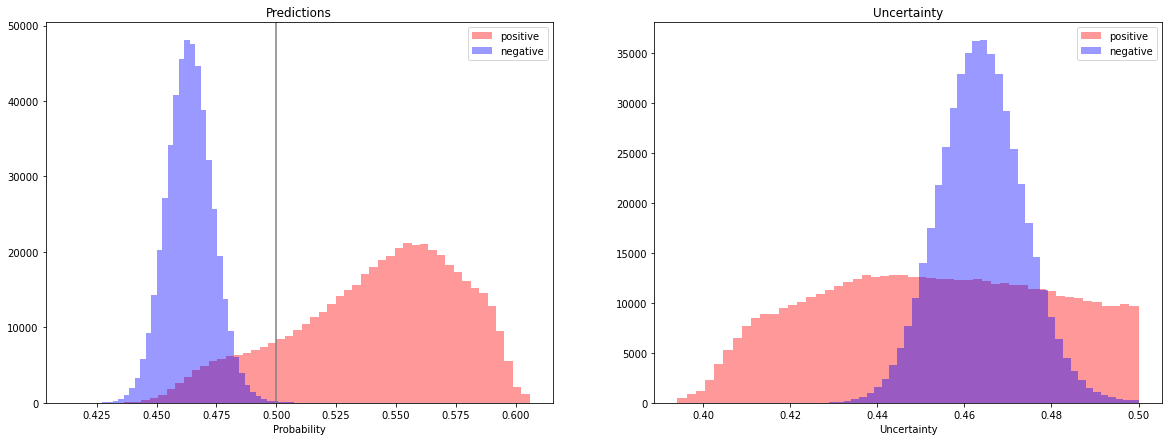

In [9]:
n_bins = 50
fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(20, 7))

ax0.hist(score_vec[label_vec == 1], bins=n_bins, color="red", label="positive", alpha=0.4)
ax0.hist(score_vec[label_vec == 0], bins=n_bins, color="blue", label="negative", alpha=0.4)
ax0.axvline(0.5, color="grey")
ax0.legend()
ax0.set_xlabel("Probability")
ax0.set_title("Predictions")


ax1.hist(uncertainty_vec[label_vec == 1], bins=n_bins, color="red", label="positive", alpha=0.4)
ax1.hist(uncertainty_vec[label_vec == 0], bins=n_bins, color="blue", label="negative", alpha=0.4)
# ax1.axvline(0.5, color="grey")
ax1.legend()
ax1.set_xlabel("Uncertainty")
ax1.set_title("Uncertainty")

### Lets's pack them into bins and look the distribution of different thinks in them

In [10]:
uncertainty_splits = np.split(uncertainty_vec, np.linspace(0, len(uncertainty_vec), 21, dtype=int)[1:-1])
uncertainty_portions = []
for idx, s in enumerate(uncertainty_splits):
#     print(f"[{idx}] {s.mean()}")
    uncertainty_portions.append(s.mean())

score_splits = np.split(score_vec, np.linspace(0, len(score_vec), 21, dtype=int)[1:-1])
score_portions = []
for idx, s in enumerate(score_splits):
#     print(f"[{idx}] {s.mean()}")
    score_portions.append(s.mean())

labels_splits = np.split(label_vec, np.linspace(0, len(label_vec), 21, dtype=int)[1:-1])
labels_portions = []
for idx, s in enumerate(labels_splits):
#     print(f"[{idx}] {s.mean()}")
    labels_portions.append(s.mean())
    

Text(0.5, 1.0, 'labels')

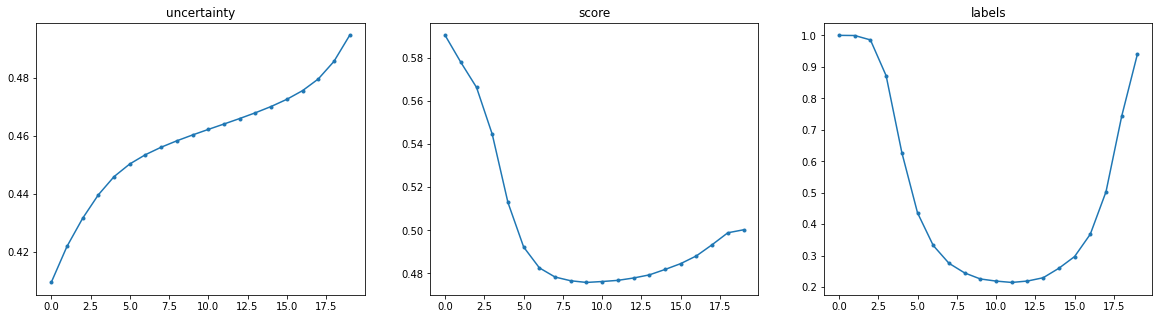

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(uncertainty_portions, marker=".")
ax1.set_title("uncertainty")

ax2.plot(score_portions, marker=".")
ax2.set_title("score")

ax3.plot(labels_portions, marker=".")
ax3.set_title("labels")

# fig.savefig("/gpfs/data/gpfs0/r.kail/figures/07_reject_labels_distribution/distribution.jpg", dpi=400)

### Let's explore distribution of labels in the remaining data, from number of filtered out things

In [12]:
del_elements = np.linspace(0, len(score_vec) // 2, 50).astype(int)
print(del_elements)

labels_threshold = [label_vec[:len(label_vec) - d].mean() for d in del_elements]
score_threshold = [score_vec[:len(label_vec) - d].mean() for d in del_elements]
uncertainty_threshold = [uncertainty_vec[:len(label_vec) - d].mean() for d in del_elements]

[     0  10204  20408  30612  40816  51020  61224  71428  81632  91836
 102040 112244 122448 132653 142857 153061 163265 173469 183673 193877
 204081 214285 224489 234693 244897 255102 265306 275510 285714 295918
 306122 316326 326530 336734 346938 357142 367346 377551 387755 397959
 408163 418367 428571 438775 448979 459183 469387 479591 489795 500000]


Text(0.5, 1.0, 'labels')

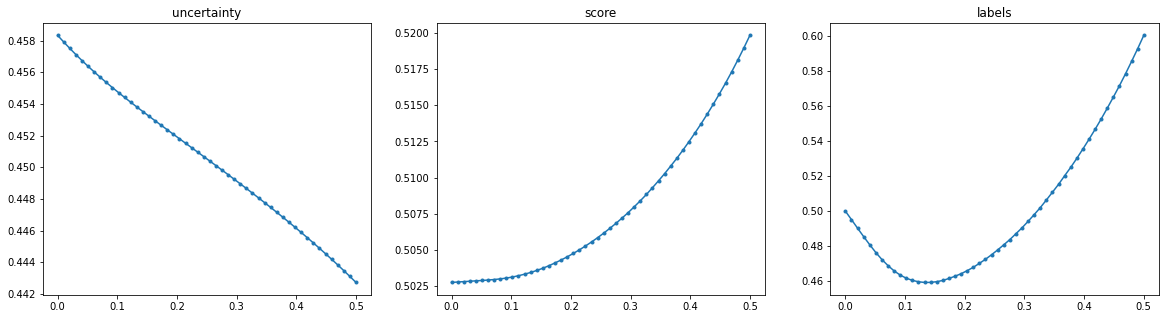

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(np.linspace(0, 0.5, 50), uncertainty_threshold, marker=".")
ax1.set_title("uncertainty")

ax2.plot(np.linspace(0, 0.5, 50), score_threshold, marker=".")
ax2.set_title("score")

ax3.plot(np.linspace(0, 0.5, 50), labels_threshold, marker=".")
ax3.set_title("labels")

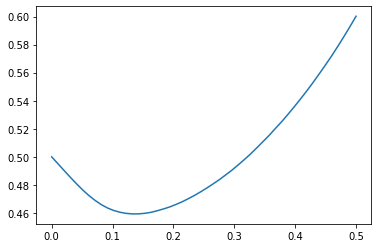

In [14]:
plt.plot(np.linspace(0, 0.5, 50), labels_threshold)

In [15]:
print(score_vec[label_vec == 1].mean(), score_vec[label_vec == 1].std())
print(score_vec[label_vec == 0].mean(), score_vec[label_vec == 0].std())

0.54160404 0.034571975
0.46391225 0.009700651


Text(0.5, 1.0, 'Uncertainty')

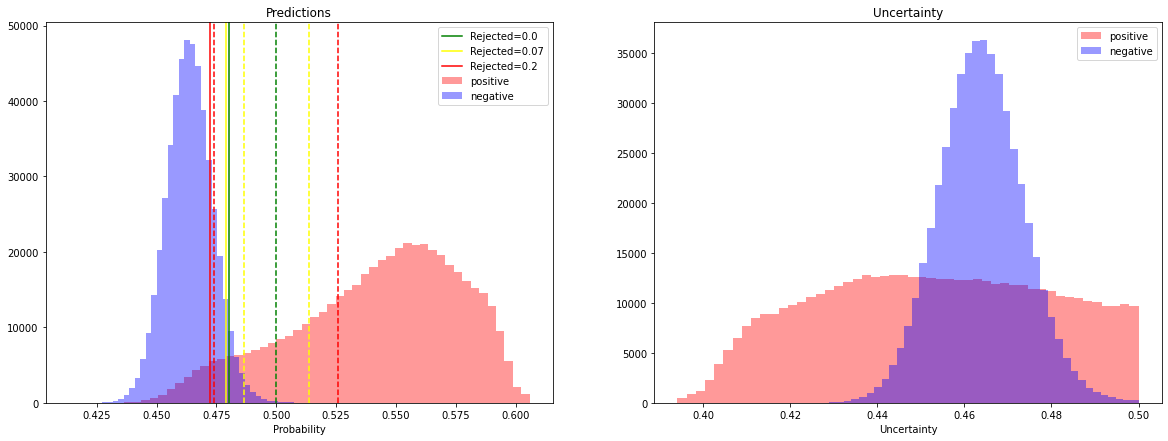

In [16]:
n_bins = 50
fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(20, 7))

ax0.hist(score_vec[label_vec == 1], bins=n_bins, color="red", label="positive", alpha=0.4)
ax0.hist(score_vec[label_vec == 0], bins=n_bins, color="blue", label="negative", alpha=0.4)
ax0.set_xlabel("Probability")
ax0.set_title("Predictions")

ax0.axvline(0.48004997, label="Rejected=0.0", color="green")
ax0.axvline(0.5, color="green", linestyle="--")

ax0.axvline(0.47889888, label="Rejected=0.07", color="yellow")
ax0.axvline(0.48640692234039307, color="yellow", linestyle="--")
ax0.axvline(1 - 0.48640692234039307, color="yellow", linestyle="--")

ax0.axvline(0.47236234, label="Rejected=0.2", color="red")
ax0.axvline(0.4740701913833618, color="red", linestyle="--")
ax0.axvline(1 - 0.4740701913833618, color="red", linestyle="--")
ax0.legend()


ax1.hist(uncertainty_vec[label_vec == 1], bins=n_bins, color="red", label="positive", alpha=0.4)
ax1.hist(uncertainty_vec[label_vec == 0], bins=n_bins, color="blue", label="negative", alpha=0.4)
# ax1.axvline(0.5, color="grey")
ax1.legend()
ax1.set_xlabel("Uncertainty")
ax1.set_title("Uncertainty")
